In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import locale
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.tsa.api import VAR


locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')
df = pd.read_csv('../data/df_analise.csv').set_index('Data')
df.index = pd.to_datetime(df.index, format='%b/%Y')
df = df.asfreq(pd.infer_freq(df.index))

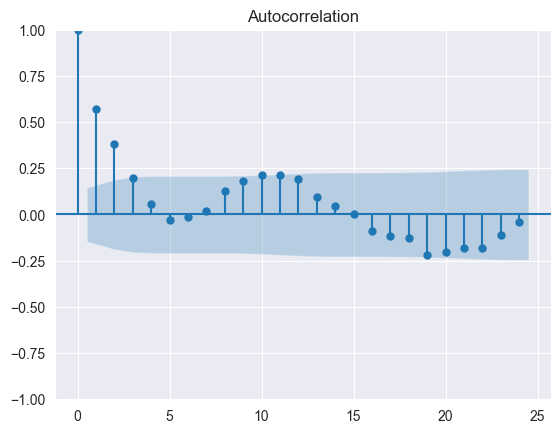

In [19]:
plot_acf(x=df['INPC'], lags=24)
plt.show()

In [20]:
result_adfuller = adfuller(df['INPC'], autolag='AIC')
print('Stationary: ' + str(result_adfuller[1] < 0.05))

Stationary: True


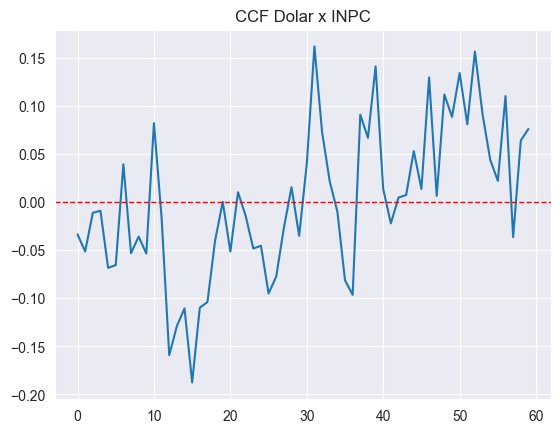

In [21]:
result_ccf = ccf(df['Dolar'], df['INPC'], adjusted=True)[:60]
plt.plot(result_ccf, label='ccf')
plt.title('CCF Dolar x INPC')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

In [22]:
model = VAR(df[['Dolar', 'INPC']])
lag_order = model.select_order(maxlags=24)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,1.179,1.218,3.252,1.195
1,0.8282*,0.9460*,2.289*,0.8761*
2,0.8617,1.058,2.367,0.9415
3,0.9074,1.182,2.478,1.019
4,0.8476,1.201,2.335,0.9912
5,0.8954,1.327,2.450,1.071
6,0.8891,1.400,2.435,1.096
7,0.9276,1.517,2.531,1.167
8,0.8636,1.531,2.376,1.135
9,0.9017,1.648,2.470,1.205


In [23]:
result_var = model.fit(maxlags=3)
print(result_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 29, abr, 2025
Time:                     04:23:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.11997
Nobs:                     176.000    HQIC:                  0.970062
Log likelihood:          -561.830    FPE:                    2.38180
AIC:                     0.867772    Det(Omega_mle):         2.20307
--------------------------------------------------------------------
Results for equation Dolar
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.044559         0.635244            1.644           0.100
L1.Dolar        -0.041765         0.076813           -0.544           0.587
L1.INPC         -0.719576         1.082123           -0.665           0.506
L2.D

In [24]:
cause = result_var.test_causality('INPC', 'Dolar', kind='f')
cause.summary()

Test statistic,Critical value,p-value,df
0.6041,2.631,0.613,"(3, 338)"


In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(result_var.resid, lags=[10], return_df=True)
print("Portmanteau Test Results:")
print(ljung_box_results)

ValueError: x is required to have ndim 1 but has ndim 2

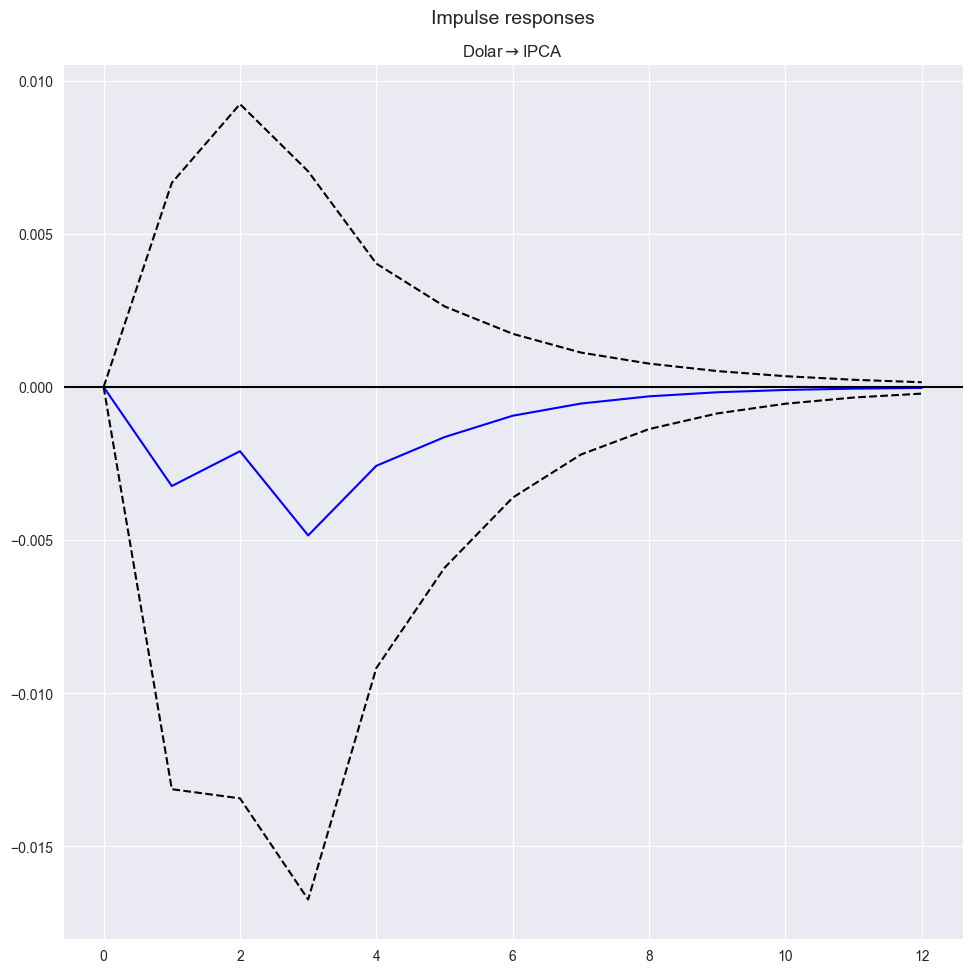

In [79]:
irf = result_var.irf(12)
irf.plot(impulse='Dolar', response='INPC')
plt.show()

In [82]:
dolar_index = 0
x_index = 1

# Respostas de x a choques no Dólar
response_x_to_dolar = irf.orth_irfs [:, dolar_index, x_index]

for month, value in enumerate(response_x_to_dolar):
    print(f"Mês {month}: {value:.5f}")

Mês 0: 0.00000
Mês 1: -0.23295
Mês 2: -0.03879
Mês 3: -0.01438
Mês 4: -0.00644
Mês 5: -0.00293
Mês 6: -0.00132
Mês 7: -0.00068
Mês 8: -0.00035
Mês 9: -0.00019
Mês 10: -0.00010
Mês 11: -0.00006
Mês 12: -0.00003


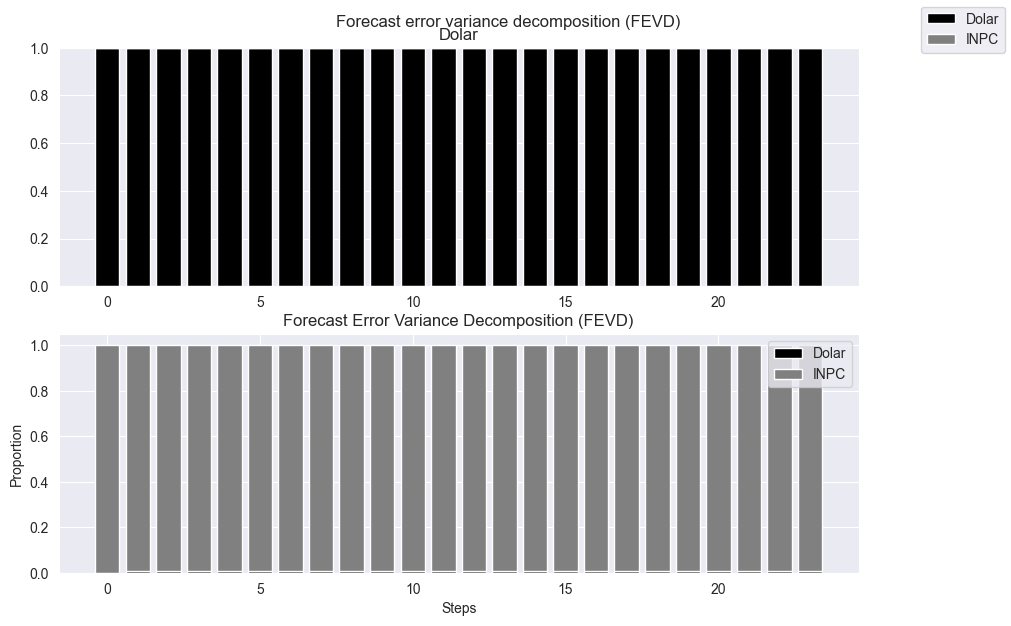

In [26]:
fevd = result_var.fevd(24)

# Plot the FEVD
fevd.plot(figsize=(10, 6))
plt.title("Forecast Error Variance Decomposition (FEVD)")
plt.xlabel("Steps")
plt.ylabel("Proportion")
plt.legend(loc='best')
plt.show()